In [3]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import time
# --- Physical Constants and Model Parameters ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv_const = 2.501e6
# Parameters from Romps (2016) and Del Genio et al. (2007)
A_ENTRAIN = 0.2 # Dimensionless entrainment parameter 'a'
PE = 0.35 # Precipitation Efficiency
A_PRIME = 1.0/6.0 # Buoyancy efficiency constant 'a'' from Del Genio
B_PRIME = 2.0/3.0 # Detrainment/drag constant 'b'' from Del Genio
# --- Core Thermodynamic & Profile Functions ---
def saturation_vapor_pressure(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0
def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    denom = np.maximum(denom, 1e-3)
    qs = epsilon * es / denom
    return np.maximum(qs, 0.0)
def calculate_entraining_mse(T, p, z, a):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv_const * qs / (1 + a)
def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz, a):
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile, p_profile = np.full(n_steps, np.nan), np.full(n_steps, np.nan)
    T_profile[0], p_profile[0] = T_surf, p_surf
    mse_conserved = calculate_entraining_mse(T_profile[0], p_profile[0], 0.0, a)
    for i in range(n_steps - 1):
        z_c, T_c, p_c = z_profile[i], T_profile[i], p_profile[i]
        if np.isnan(T_c) or p_c <= 0: break
        z_n = z_profile[i+1]
        Tv_c = T_c * (1 + (1/epsilon - 1) * saturation_specific_humidity(p_c, T_c))
        H = (Rd * Tv_c) / g
        p_n = p_c * np.exp(-dz / H)
        if p_n <= 0: break
        def res(T_g): return calculate_entraining_mse(T_g, p_n, z_n, a) - mse_conserved
        try:
            sol = root_scalar(res, bracket=[50.0, T_c], method='brentq')
            if sol.converged: T_profile[i+1], p_profile[i+1] = sol.root, p_n
            else: break
        except (ValueError, RuntimeError): break
    valid = ~np.isnan(T_profile)
    return z_profile[valid], T_profile[valid], p_profile[valid]
print("--- Starting Main Calculation ---")
start_time = time.time()
# --- Parameters ---
p_surf_pa = 100000.0
Z_MAX_M = 25000 # Calculate up to 25km
T_surf_values = np.arange(280, 320.1, 1.0)
z_grid_m = np.arange(0, Z_MAX_M, 100)
z_grid_km = z_grid_m / 1000.0
velocity_grid = np.full((len(z_grid_m), len(T_surf_values)), np.nan)
# --- Calculation Loop ---
for i, t_surf in enumerate(T_surf_values):
    print(f"Processing Ts = {t_surf:.1f} K...")
    # 1. Calculate Environment and Parcel Profiles
    z_env, t_env, p_env = calculate_moist_adiabatic_profile(t_surf, p_surf_pa, Z_MAX_M, 100, a=A_ENTRAIN)
    z_par, t_par, _ = calculate_moist_adiabatic_profile(t_surf, p_surf_pa, Z_MAX_M, 100, a=0)
    if len(z_env) < 2 or len(z_par) < 2: 
        print(f" -> Failed to generate complete profiles for Ts = {t_surf:.1f} K.")
        continue
    # 2. Create interpolating functions for Buoyancy and Entrainment Rate
    interp_t_env = interp1d(z_env, t_env, bounds_error=False, fill_value=np.nan)
    interp_p_env = interp1d(z_env, p_env, bounds_error=False, fill_value=np.nan)
    interp_t_par = interp1d(z_par, t_par, bounds_error=False, fill_value=np.nan)
    t_env_on_grid = interp_t_env(z_grid_m)
    p_env_on_grid = interp_p_env(z_grid_m)
    t_par_on_grid = interp_t_par(z_grid_m)
    delta_t = t_par_on_grid - t_env_on_grid
    buoyancy_on_grid = g * delta_t / t_env_on_grid
    buoyancy_on_grid[buoyancy_on_grid < 0] = 0
    buoyancy_on_grid = np.nan_to_num(buoyancy_on_grid)
    buoyancy_func = interp1d(z_grid_m, buoyancy_on_grid, bounds_error=False, fill_value=0)
    qs_env = saturation_specific_humidity(p_env_on_grid, t_env_on_grid)
    gamma = -np.gradient(np.log(qs_env), z_grid_m)
    entrainment_rate_on_grid = (A_ENTRAIN * gamma) / PE
    entrainment_rate_on_grid = np.nan_to_num(entrainment_rate_on_grid)
    entrainment_func = interp1d(z_grid_m, entrainment_rate_on_grid, bounds_error=False, fill_value=0)
    # 3. Define and solve the momentum ODE
    def momentum_ode(z, y):
        # y[0] is w_squared
        w_sq = y[0]
        B = buoyancy_func(z)
        E = entrainment_func(z)
        drag_term = (A_PRIME + B_PRIME) * E * w_sq
        dw_sq_dz = 2 * (A_PRIME * B - drag_term)
        return [dw_sq_dz]
    sol = solve_ivp(momentum_ode, [0, Z_MAX_M], [0], dense_output=True, method='RK45')
    w_sq_sol = sol.sol(z_grid_m)[0]
    w_sq_sol[w_sq_sol < 0] = 0
    velocity_grid[:, i] = np.sqrt(w_sq_sol)
print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

--- Starting Main Calculation ---
Processing Ts = 280.0 K...
Processing Ts = 281.0 K...
Processing Ts = 282.0 K...
Processing Ts = 283.0 K...
Processing Ts = 284.0 K...
Processing Ts = 285.0 K...
Processing Ts = 286.0 K...
Processing Ts = 287.0 K...
Processing Ts = 288.0 K...
Processing Ts = 289.0 K...
Processing Ts = 290.0 K...
Processing Ts = 291.0 K...
Processing Ts = 292.0 K...
Processing Ts = 293.0 K...
Processing Ts = 294.0 K...
Processing Ts = 295.0 K...
Processing Ts = 296.0 K...
Processing Ts = 297.0 K...
Processing Ts = 298.0 K...
Processing Ts = 299.0 K...
Processing Ts = 300.0 K...
Processing Ts = 301.0 K...
Processing Ts = 302.0 K...
Processing Ts = 303.0 K...
Processing Ts = 304.0 K...
Processing Ts = 305.0 K...
Processing Ts = 306.0 K...
Processing Ts = 307.0 K...
Processing Ts = 308.0 K...
Processing Ts = 309.0 K...
Processing Ts = 310.0 K...
Processing Ts = 311.0 K...
Processing Ts = 312.0 K...
Processing Ts = 313.0 K...
Processing Ts = 314.0 K...
Processing Ts = 315.0

--- Generating Figure 7 ---


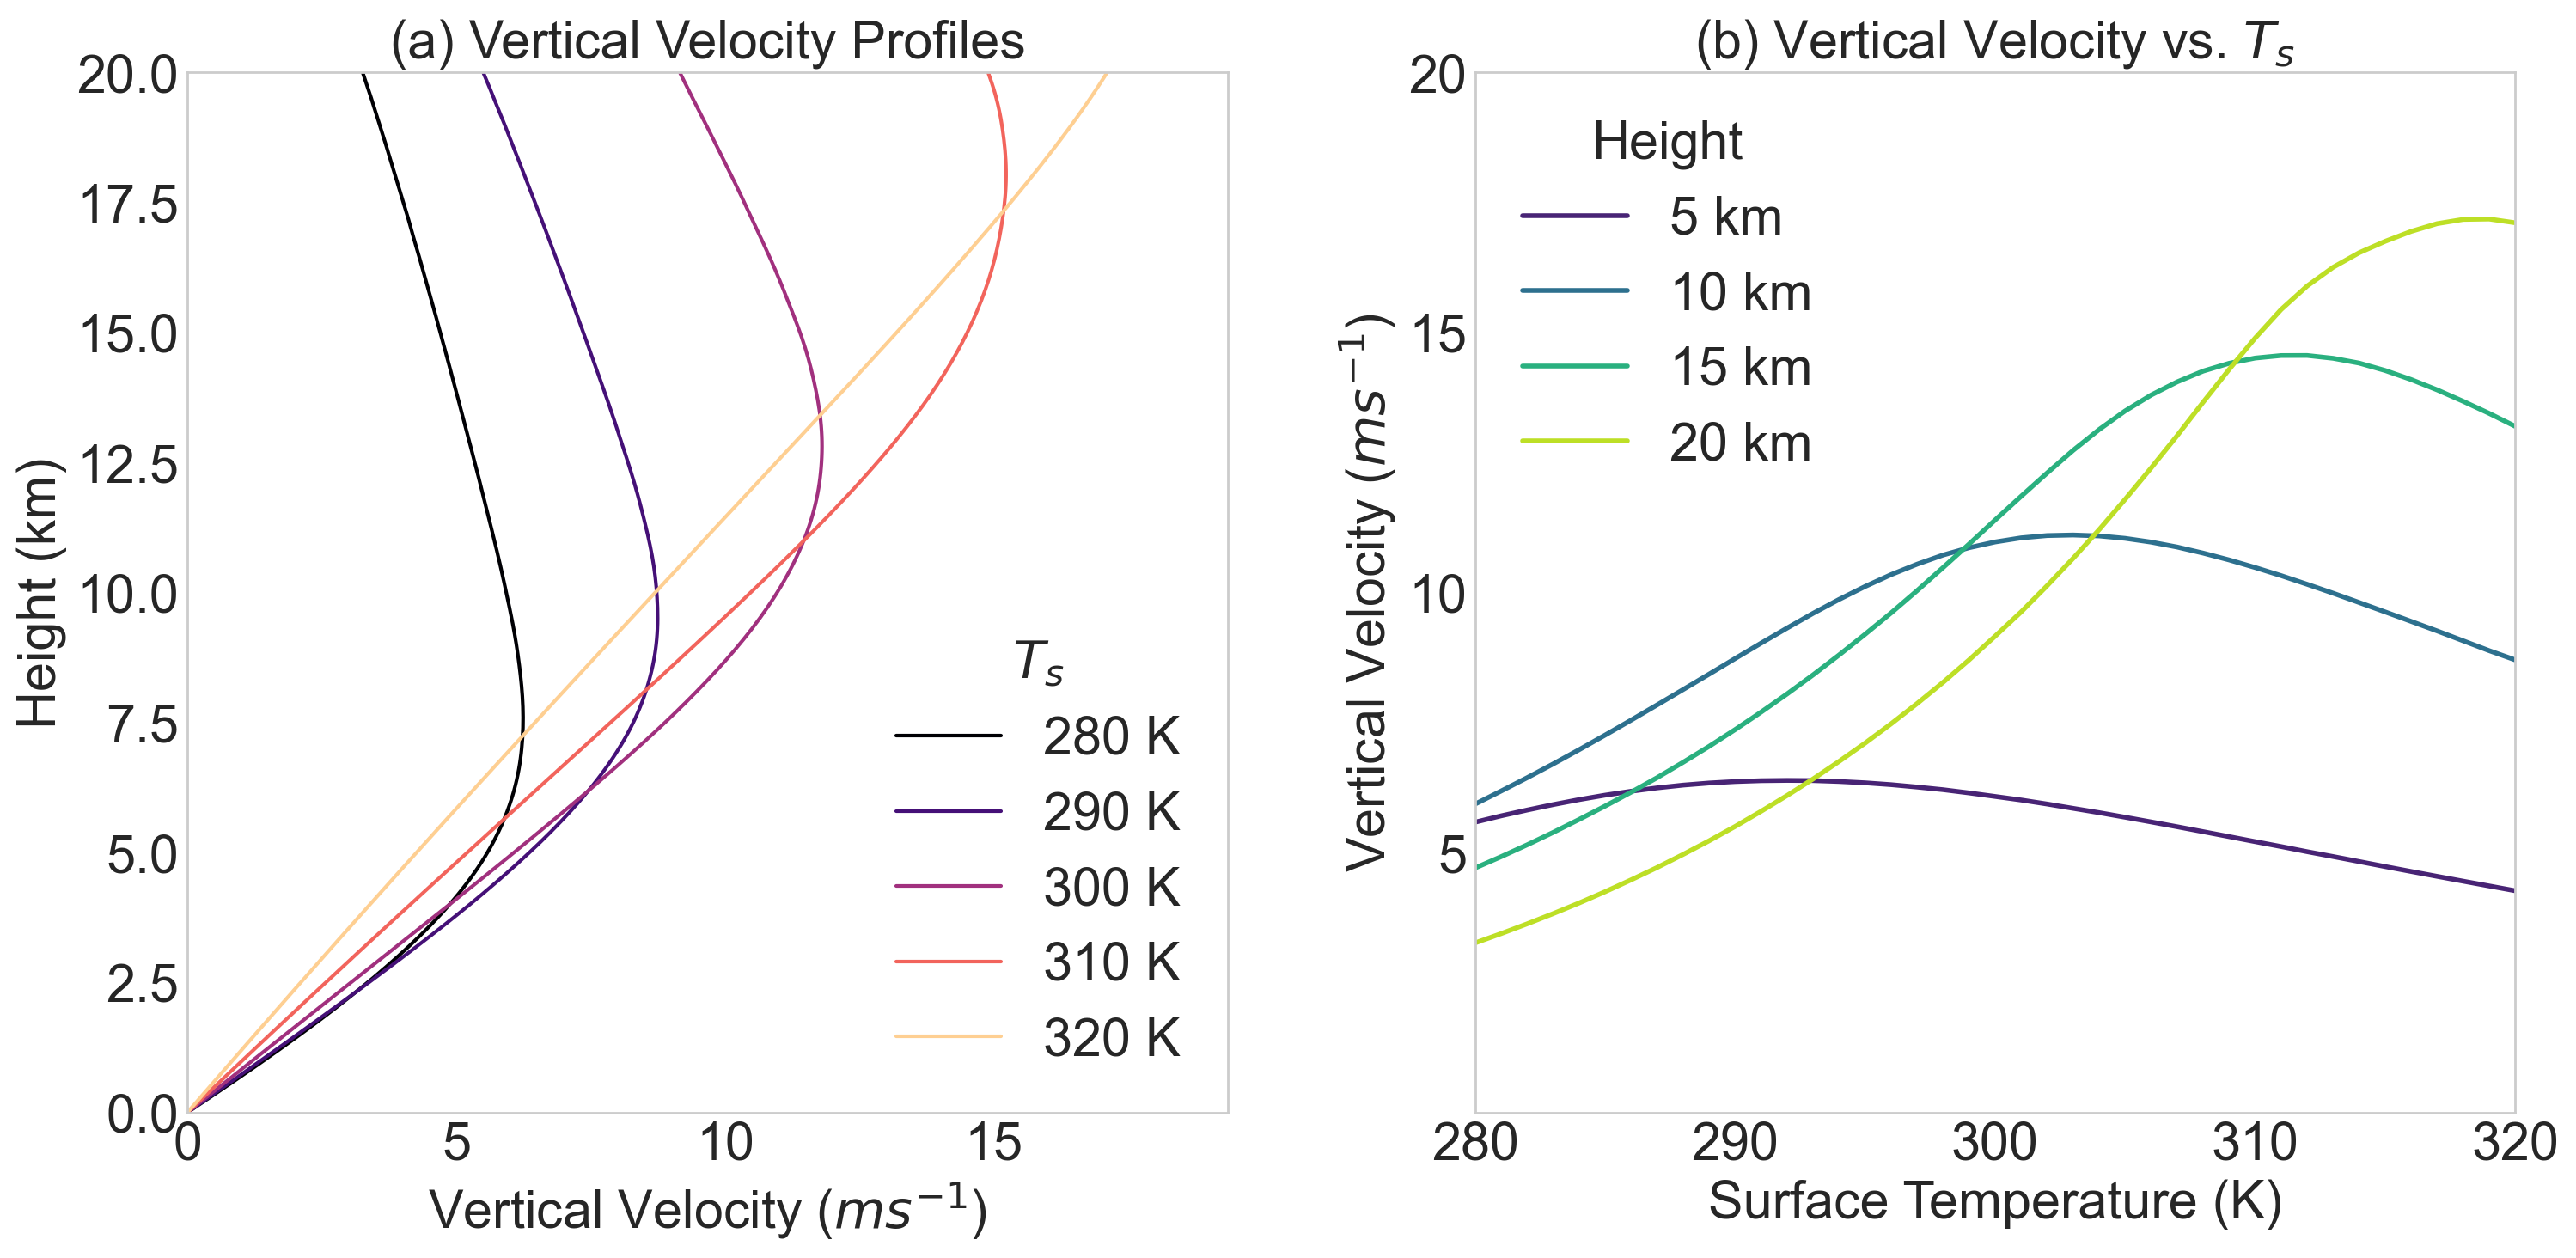

Figure 7 saved as fig-7.png

Script finished.


In [4]:
print("--- Generating Figure 7 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize,
    'figure.titlesize': base_fontsize + 2
})
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# --- Panel (a): Vertical Velocity Profiles ---
ax1 = axes[0]
T_plot_values = [280, 290, 300, 310, 320]
cmap = plt.get_cmap('magma')
colors = cmap(np.linspace(0, 0.9, len(T_plot_values)))
for i, t_surf_val in enumerate(T_plot_values):
    t_idx = np.argmin(np.abs(T_surf_values - t_surf_val))
    ax1.plot(velocity_grid[:, t_idx], z_grid_km, color=colors[i], label=f'{t_surf_val} K')
ax1.set_xlabel('Vertical Velocity ($m s^{-1}$)')
ax1.set_ylabel('Height (km)')
ax1.set_title('(a) Vertical Velocity Profiles')
ax1.legend(title='$T_{s}$')
ax1.tick_params(axis='both', which='major')
ax1.set_ylim(0, 20)
ax1.set_xlim(left=0)
ax1.grid(False)
ax1.set_box_aspect(1)
# --- Panel (b): Vertical velocity at fixed heights ---
ax2 = axes[1]
z_levels_km = [5, 10, 15, 20]
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0.1, 0.9, len(z_levels_km)))
for i, z_km in enumerate(z_levels_km):
    z_idx = np.argmin(np.abs(z_grid_km - z_km))
    ax2.plot(T_surf_values, velocity_grid[z_idx, :], color=colors[i], label=f'{z_km} km', linewidth=2)
ax2.set_xlabel('Surface Temperature (K)')
ax2.set_ylabel('Vertical Velocity ($m s^{-1}$)')
ax2.set_title('(b) Vertical Velocity vs. $T_{s}$')
ax2.legend(title='Height')
ax2.tick_params(axis='both', which='major')
ax2.set_xlim(280, 320)
ax2.set_ylim(bottom=0)
ax2.set_yticks(np.arange(5, np.nanmax(velocity_grid)+5, 5))
ax2.grid(False)
ax2.set_box_aspect(1)
plt.tight_layout(pad=2.0)
fig7_filename = "fig-7.png"
plt.savefig(fig7_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 7 saved as {fig7_filename}")
print("\nScript finished.")
